# Genetski algoritmi

In [1]:
#+ stvori populaciju; 
#+ evaluiraj populaciju; // svaka jedinka ima pridruženu dobrotu
# ponavljaj
#  odaberi slucajno 3 jedinke;
#  izbaci najlosiju od 3 odabrane iz populacije;
#  nova_jedinka = krizanje(preostale dvije);
#  obavi mutaciju na novoj jedinki uz vjerojatnost p_M;
#  evaluiraj novu jedinku;
#  dodaj novu jedinku u populaciju;
# dok (nije zadovoljen uvjet zaustavljanja); 

In [31]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import log, ceil, sin, sqrt
from enum import Enum

In [10]:
class GenetskiAlgoritam:

    def __init__(self, prikaz, velicina, dg, gg, dimenzije, p_mutacije, p_krizanja=None, preciznost=0, br_evaluacija_fje_cilja=None, epsilon=1e-6, k=3, ispis=True):
        self.prikaz = prikaz
        self.velicina = velicina
        self.dg = dg
        self.gg = gg
        self.dimenzije = dimenzije
        self.k = k
        self.p_mutacije = p_mutacije
        self.p_krizanja = p_krizanja
        self.preciznost = preciznost
        self.br_evaluacija_fje_cilja = br_evaluacija_fje_cilja
        self.epsilon = epsilon
        self.ispis = ispis
        self.najbolje = []
    
    def stvori_populaciju(self, func):
        populacija = []
        for i in range(self.velicina):
            kromosom = Kromosom(self.prikaz, self.dg, self.gg, self.dimenzije, self.preciznost)
            kromosom.izracunaj_dobrotu(func)
            populacija.append(kromosom)
        populacija.sort(key=lambda jedinka: jedinka.dobrota)
        return populacija
    
    def pokreni(self, func, vrsta_krizanja, vrsta_mutacije):
        populacija = self.stvori_populaciju(func)
        count = 0

        while True:
            count += 1
            populacija.sort(key=lambda kromosom: kromosom.dobrota)
            if abs(populacija[-1].dobrota) <= self.epsilon:
                print("Dosegnut je minimum fje cilja."); break
            if func.br_poziva > self.br_evaluacija_fje_cilja:
                print("Dosegnut je maksimalan broj evaluacija fje cilja."); break
            
            if self.ispis == True and count % 3000 == 0: 
                print("Trenutna najbolja jedinka je: ", populacija[-1])
                print("Vrijednost funkcije cilja za nju je: ", populacija[-1].dobrota, "\n") 

            turnir = Turnir(self.k, vrsta_krizanja, vrsta_mutacije)
            self.najbolje.append(-populacija[-1].dobrota)
            populacija = turnir.novaPopulacija(func, populacija, self.p_mutacije, self.p_krizanja)
            
        
        populacija.sort(key=lambda jedinka: jedinka.dobrota)
        print("Najbolja jedinka je: ", populacija[-1])
        print("Vrijednost funkcije dobrote za nju je: ", populacija[-1].dobrota, "\n")
        rez = []
        if self.prikaz == Prikaz.binarni:
            rez.append(populacija[-1].bin_u_dek())
        else:
            rez.append(populacija[-1])
        rez.append(populacija[-1].dobrota)
        return rez


In [11]:
class Funkcija:
    
    def __init__(self, f):
        self.f = f
        self.br_poziva = 0
        self.vrijednosti = {}
    
    def vrijednost(self, x):
        self.br_poziva += 1
        try:
            return self.vrijednosti[str(x)]
        except: 
            self.vrijednosti[str(x)] = self.f(x)
            return self.vrijednosti[str(x)]
    
    def reset(self):
        self.vrijednosti = {}
        self.br_poziva = 0

# funkcije 

def f1(x):
    return 100 * (x[1] - (x[0])**2)**2 + (1 - x[0])**2

def f3(x):
    return sum([(x[i] - (i + 1))**2 for i in range(len(x))])

def f6(x):
    suma = sum([x[i]**2 for i in range(len(x))])
    return 0.5 + ((sin(sqrt(suma))**2) - 0.5) / ((1 + 0.001 * suma)**2)

def f7(x):
    suma = sum([x[i]**2 for i in range(len(x))])
    return (suma**0.25) * (1 + (sin(50*(suma**0.1))**2))

In [12]:
# - KROMOSOM -

class Prikaz(Enum):
    binarni = 1
    realni = 2

class Kromosom():
    
    def __init__(self, prikaz, dg, gg, dimenzije, preciznost=None, vrijednost=None):
        self.prikaz = prikaz
        self.dg = dg 
        self.gg = gg 
        self.dimenzije = dimenzije
        self.preciznost = preciznost

        if vrijednost is not None:
            self.vrijednost = vrijednost
        else:
            self.vrijednost = self.stvori_kromosom()
        self.dobrota = None

    def stvori_kromosom(self):
        if self.prikaz == Prikaz.binarni:
            kromosom = []
            for i in range(self.dimenzije):
                duljina = ceil(log((self.gg-self.dg)*(10**self.preciznost)+1)/(log(2)))
                kromosom.append(np.array([np.random.randint(0, 2) for i in range(duljina)]))
            return np.array(kromosom)
        else:
            d = np.full((self.dimenzije, ), self.dg)
            g = np.full((self.dimenzije, ), self.gg)
            rand = np.random.rand(self.dimenzije,)
            return d + rand * (g - d)

    def izracunaj_dobrotu(self, func):
        if self.prikaz == Prikaz.realni:
            self.dobrota = - func.vrijednost(self.vrijednost)
        else:
            duljina = ceil(log((self.gg-self.dg)*(10**self.preciznost)+1)/(log(2)))
            brojevi = []
            for i in range(len(self.vrijednost)):
                b = int(''.join(map(str, self.vrijednost[i])), 2)
                brojevi.append(self.dg + (b / (2**duljina))*(self.gg - self.dg))

            self.dobrota = -func.vrijednost(np.array(brojevi))

    def bin_u_dek(self):
        duljina = ceil(log((self.gg-self.dg)*(10**self.preciznost)+1)/(log(2)))
        brojevi = []
        for i in range(len(self.vrijednost)):
            b = int(''.join(map(str, self.vrijednost[i])), 2)
            brojevi.append(self.dg + (b / (2**duljina))*(self.gg - self.dg))
        return brojevi

    
    def __repr__(self):
        return str(self.vrijednost)

    def __str__(self):
        if self.prikaz == Prikaz.realni: return str(self.vrijednost)
        else: return str(self.bin_u_dek())


In [13]:
# - MUTACIJA -

class VrstaMutacije(Enum):
    uniformna_b = 1
    uniformna_r = 2
    gauss = 3
    
def mutacija(vrsta, func, kromosom, p_mutacije):
    mutirana_vrijednost = kromosom.vrijednost.copy()
    for i in range(kromosom.dimenzije):
        if np.random.rand() <= p_mutacije:
            
            # uniformno - binarno
            if vrsta == VrstaMutacije.uniformna_b:
                for bit in range(len(mutirana_vrijednost[i])):
                    mutirana_vrijednost[i][bit] = 1 - mutirana_vrijednost[i][bit]
            # uniformno - realno 
            elif vrsta == VrstaMutacije.uniformna_r:
                mutirana_vrijednost[i] = kromosom.dg + (np.random.rand() * (kromosom.gg - kromosom.dg))
            

    mutirani_kromosom = Kromosom(kromosom.prikaz, kromosom.dg, kromosom.gg, kromosom.dimenzije, kromosom.preciznost, mutirana_vrijednost)
    mutirani_kromosom.izracunaj_dobrotu(func)
    return mutirani_kromosom


In [14]:
# - KRIZANJE -
    
def krizanje_uniformno(func, roditelji, p_krizanja):
    dijete = Kromosom(roditelji[0].prikaz ,roditelji[0].dg, roditelji[0].gg, roditelji[0].dimenzije, roditelji[0].preciznost)
    prvi = roditelji[0].vrijednost.copy()
    drugi = roditelji[1].vrijednost.copy()
    for i in range(roditelji[0].dimenzije):
        for j in range(len(prvi[i])):
            if prvi[i][j] == drugi[i][j] or np.random.rand() < 0.5:
                dijete.vrijednost[i][j] = prvi[i][j]
            else:
                dijete.vrijednost[i][j] = drugi[i][j]
    dijete.izracunaj_dobrotu(func)
    return dijete

def krizanje_jednom_tockom(func, roditelji, p_krizanja):
    dijete = Kromosom(roditelji[0].prikaz ,roditelji[0].dg, roditelji[0].gg, roditelji[0].dimenzije, roditelji[0].preciznost)
    prvi = roditelji[0].vrijednost.copy()
    drugi = roditelji[1].vrijednost.copy()
    for i in range(roditelji[0].dimenzije):
        tocka_krizanja = np.random.randint(len(prvi[i]))
        for j in range(tocka_krizanja):
            dijete.vrijednost[i][j] = prvi[i][j]
        for j in range(tocka_krizanja, len(prvi[i])):
            dijete.vrijednost[i][j] = drugi[i][j]
    dijete.izracunaj_dobrotu(func)
    return dijete


def krizanje_aritmeticko(func, roditelji, p_krizanja):
    r = np.random.rand()
    dijete_vrijednost = r*roditelji[0].vrijednost + (1-r)*roditelji[1].vrijednost
    dijete = Kromosom(roditelji[0].prikaz, roditelji[0].dg, roditelji[0].gg, roditelji[0].dimenzije, roditelji[0].preciznost, dijete_vrijednost)
    dijete.izracunaj_dobrotu(func)
    return dijete

def krizanje_heuristicko(func, roditelji, p_krizanja):
    r = np.random.rand()
    roditelji.sort(key=lambda roditelj: roditelj.dobrota)
    dijete_vrijednost = r * (roditelji[1].vrijednost - roditelji[0].vrijednost) + roditelji[1].vrijednost
    for i in range(len(dijete_vrijednost)):
        if dijete_vrijednost[i] < roditelji[0].dg:
            dijete_vrijednost[i] = roditelji[0].dg
        elif dijete_vrijednost[i] > roditelji[0].gg:
            dijete_vrijednost[i] = roditelji[0].gg
    
    dijete = Kromosom(roditelji[0].prikaz, roditelji[0].dg, roditelji[0].gg, roditelji[0].dimenzije, roditelji[0].preciznost, dijete_vrijednost)
    dijete.izracunaj_dobrotu(func)
    return dijete
    

In [15]:
class Turnir:

    def __init__(self, k, krizanje, vrsta_mutacije):
        self.k = k
        self.krizanje = krizanje
        self.vrsta_mutacije = vrsta_mutacije
    
    def novaPopulacija(self, func, populacija, p_mutacije, p_krizanja=None):
        indeksi_kandidata = self.izaberi_indekse(populacija)
        indeksi_kandidata.sort(key=lambda indeks: populacija[indeks].dobrota, reverse=True)
        roditelji = [populacija[indeksi_kandidata[1]], populacija[indeksi_kandidata[2]]]
        
        dijete = self.krizanje(func, roditelji, p_krizanja)
        dijete = mutacija(self.vrsta_mutacije, func, dijete, p_mutacije)

        nova_populacija = populacija 
        nova_populacija[indeksi_kandidata[-1]] = dijete
        return nova_populacija
    
    def izaberi_indekse(self, populacija):
        indeksi = set(np.random.randint(len(populacija), size=self.k))
        while len(indeksi) < self.k:
            indeksi.add(np.random.randint(len(populacija)))
        return list(indeksi)
            

# Zadatci

1. Isprobajte vašu implementaciju GA nad svim funkcijama uz granice [-50, 150] za sve varijable te za
oba prikaza rješenja (binarni, s pomičnom točkom). Za binarni prikaz zadajte preciznost od barem tri
decimalna mjesta. Za funkciju f3 odaberite barem 5 varijabli, a za f6 i f7 dvije varijable. Za sve
funkcije možete smatrati da je rješenje pronađeno ako je krajnja vrijednost funkcije cilja manja od
10-6. Za neke funkcije algoritam će biti potrebno pokrenuti nekoliko puta. Koje zaključke možete
donijeti o uspješnosti GA za pojedinu funkciju? Koje su se funkcije pokazale teškima i zašto? 

In [16]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.049, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f1), krizanje_heuristicko ,VrstaMutacije.uniformna_r)

Trenutna najbolja jedinka je:  [1.00106388 1.00204117]
Vrijednost funkcije cilja za nju je:  -1.901370483406165e-06 

Dosegnut je minimum fje cilja.
Najbolja jedinka je:  [0.9999147  0.99975132]
Vrijednost funkcije dobrote za nju je:  -6.171204043161715e-07 



In [17]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=5, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f3), krizanje_aritmeticko ,VrstaMutacije.uniformna_r)

Trenutna najbolja jedinka je:  [1.36535961 2.94784721 4.36035315 6.93075592 5.00933014]
Vrijednost funkcije cilja za nju je:  -11.471880000002121 

Trenutna najbolja jedinka je:  [0.74410882 3.64784518 4.15119356 4.03716061 5.07675142]
Vrijednost funkcije cilja za nju je:  -4.113392328394985 

Trenutna najbolja jedinka je:  [0.16107441 2.76936747 3.42212067 4.42085077 5.20682951]
Vrijednost funkcije cilja za nju je:  -1.6938021291549554 

Trenutna najbolja jedinka je:  [1.29100656 2.27767216 2.5688877  4.42835658 5.13302611]
Vrijednost funkcije cilja za nju je:  -0.5488297670720093 

Trenutna najbolja jedinka je:  [1.34198237 2.27494547 3.01138011 4.18142924 5.21321894]
Vrijednost funkcije cilja za nju je:  -0.2710553438474386 

Trenutna najbolja jedinka je:  [0.78519316 1.94925633 2.97431756 4.13794409 5.19150977]
Vrijednost funkcije cilja za nju je:  -0.10508104960271175 

Trenutna najbolja jedinka je:  [1.04165798 2.17939355 2.99454935 4.04804909 5.13397388]
Vrijednost funkcije cilj

In [18]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f6), krizanje_aritmeticko ,VrstaMutacije.uniformna_r)

Trenutna najbolja jedinka je:  [1.59794897 2.70121347]
Vrijednost funkcije cilja za nju je:  -0.009715910087697566 

Trenutna najbolja jedinka je:  [1.5812003  2.71106122]
Vrijednost funkcije cilja za nju je:  -0.009715909916627186 

Trenutna najbolja jedinka je:  [1.49939562 2.75715444]
Vrijednost funkcije cilja za nju je:  -0.009715909877531292 

Trenutna najbolja jedinka je:  [1.49939562 2.75715444]
Vrijednost funkcije cilja za nju je:  -0.009715909877531292 

Trenutna najbolja jedinka je:  [-0.00329205  0.03899287]
Vrijednost funkcije cilja za nju je:  -0.0015320265912852626 

Trenutna najbolja jedinka je:  [-0.00329205  0.03899287]
Vrijednost funkcije cilja za nju je:  -0.0015320265912852626 

Trenutna najbolja jedinka je:  [-0.00329205  0.03899287]
Vrijednost funkcije cilja za nju je:  -0.0015320265912852626 

Trenutna najbolja jedinka je:  [-0.00329205  0.03899287]
Vrijednost funkcije cilja za nju je:  -0.0015320265912852626 

Trenutna najbolja jedinka je:  [-0.00329205  0.03899

In [19]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f7), krizanje_heuristicko ,VrstaMutacije.uniformna_r)

Trenutna najbolja jedinka je:  [-0.01590982 -0.00124836]
Vrijednost funkcije cilja za nju je:  -0.12862301513554805 

Trenutna najbolja jedinka je:  [ 0.00017382 -0.00017089]
Vrijednost funkcije cilja za nju je:  -0.0156449518155259 

Trenutna najbolja jedinka je:  [-3.93211298e-05 -4.99927734e-05]
Vrijednost funkcije cilja za nju je:  -0.013294212430445422 

Trenutna najbolja jedinka je:  [-3.93211298e-05 -4.99927734e-05]
Vrijednost funkcije cilja za nju je:  -0.013294212430445422 

Trenutna najbolja jedinka je:  [-3.93211298e-05 -4.99927734e-05]
Vrijednost funkcije cilja za nju je:  -0.013294212430445422 

Trenutna najbolja jedinka je:  [ 6.50029512e-06 -2.54071609e-05]
Vrijednost funkcije cilja za nju je:  -0.00536454757779945 

Trenutna najbolja jedinka je:  [ 6.50029512e-06 -2.54071609e-05]
Vrijednost funkcije cilja za nju je:  -0.00536454757779945 

Trenutna najbolja jedinka je:  [ 6.50029512e-06 -2.54071609e-05]
Vrijednost funkcije cilja za nju je:  -0.00536454757779945 

Trenut

In [20]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.049, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f1), krizanje_uniformno ,VrstaMutacije.uniformna_b)

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.5625, 2.34375]
Vrijednost funkcije cilja za nju je:  -1.27008056640625 

Trenutna najbolja jedinka je:  [1.562

In [21]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=5, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f3), krizanje_uniformno ,VrstaMutacije.uniformna_b)

Trenutna najbolja jedinka je:  [6.25, -7.03125, -0.78125, 7.03125, -1.5625]
Vrijednost funkcije cilja za nju je:  -175.6787109375 

Trenutna najbolja jedinka je:  [-3.125, -3.125, -3.125, 4.6875, -2.34375]
Vrijednost funkcije cilja za nju je:  -135.2001953125 

Trenutna najbolja jedinka je:  [-1.5625, 1.5625, 1.5625, 6.25, 8.59375]
Vrijednost funkcije cilja za nju je:  -26.8017578125 

Trenutna najbolja jedinka je:  [-1.5625, 1.5625, 1.5625, 6.25, 8.59375]
Vrijednost funkcije cilja za nju je:  -26.8017578125 

Trenutna najbolja jedinka je:  [-1.5625, 1.5625, 1.5625, 6.25, 8.59375]
Vrijednost funkcije cilja za nju je:  -26.8017578125 

Trenutna najbolja jedinka je:  [-1.5625, 1.5625, 1.5625, 6.25, 8.59375]
Vrijednost funkcije cilja za nju je:  -26.8017578125 

Trenutna najbolja jedinka je:  [-2.34375, 1.5625, 3.125, 1.5625, 3.90625]
Vrijednost funkcije cilja za nju je:  -18.525390625 

Trenutna najbolja jedinka je:  [-0.78125, -1.5625, 1.5625, 4.6875, 4.6875]
Vrijednost funkcije cilja z

In [22]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=5, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f3), krizanje_jednom_tockom ,VrstaMutacije.uniformna_b)

Trenutna najbolja jedinka je:  [-0.78125, 0.78125, 3.90625, 3.90625, 6.25]
Vrijednost funkcije cilja za nju je:  -7.05078125 

Trenutna najbolja jedinka je:  [1.5625, 2.34375, 2.34375, 3.90625, 5.46875]
Vrijednost funkcije cilja za nju je:  -1.09375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju je:  -0.2880859375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju je:  -0.2880859375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju je:  -0.2880859375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju je:  -0.2880859375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju je:  -0.2880859375 

Trenutna najbolja jedinka je:  [0.78125, 2.34375, 3.125, 3.90625, 4.6875]
Vrijednost funkcije cilja za nju j

In [23]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f6), krizanje_uniformno, VrstaMutacije.uniformna_b)

Trenutna najbolja jedinka je:  [-3.125, 0.0]
Vrijednost funkcije cilja za nju je:  -0.009894405884560975 

Trenutna najbolja jedinka je:  [-3.125, 0.0]
Vrijednost funkcije cilja za nju je:  -0.009894405884560975 

Dosegnut je minimum fje cilja.
Najbolja jedinka je:  [0.0, 0.0]
Vrijednost funkcije dobrote za nju je:  -0.0 



In [24]:
gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=100000, epsilon=1e-6)
rez = gen_alg.pokreni(Funkcija(f7), krizanje_uniformno,VrstaMutacije.uniformna_b)

Dosegnut je minimum fje cilja.
Najbolja jedinka je:  [0.0, 0.0]
Vrijednost funkcije dobrote za nju je:  -0.0 



2. Provedite GA na funkcijama f6 i f7 mijenjajući dimenzionalnost funkcije (1, 3, 6, 10). Kako
povećanje dimenzionalnosti funkcije utječe na ponašanje algoritma?

In [25]:
rez_f6 = []
rez_f7 = []

for dim in [1, 3, 6, 10]:
    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, br_evaluacija_fje_cilja=10000, epsilon=1e-6, ispis=False)
    rez_f6.append(gen_alg.pokreni(Funkcija(f6), krizanje_uniformno, VrstaMutacije.uniformna_b)[1])

    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, br_evaluacija_fje_cilja=10000, epsilon=1e-6, ispis=False)
    rez_f7.append(gen_alg.pokreni(Funkcija(f7), krizanje_uniformno, VrstaMutacije.uniformna_b)[1])

pd.DataFrame(np.column_stack((rez_f6, rez_f7)), [1, 3, 6, 10], columns=['dobrota f6', 'dobrota f7'])

Dosegnut je minimum fje cilja.
Najbolja jedinka je:  [0.0]
Vrijednost funkcije dobrote za nju je:  -0.0 

Dosegnut je minimum fje cilja.
Najbolja jedinka je:  [0.0]
Vrijednost funkcije dobrote za nju je:  -0.0 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [5.46875, -7.03125, -3.125]
Vrijednost funkcije dobrote za nju je:  -0.07866519909900771 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-0.78125, -0.78125, -1.5625]
Vrijednost funkcije dobrote za nju je:  -1.575192770722792 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [4.6875, 10.15625, 12.5, 7.8125, -4.6875, -16.40625]
Vrijednost funkcije dobrote za nju je:  -0.31315554793301337 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-3.90625, -14.84375, -7.8125, -2.34375, -9.375, -2.34375]
Vrijednost funkcije dobrote za nju je:  -4.603604464214859 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [17.1875, 

,dobrota f6,dobrota f7
1,-0.000000,-0.000000
3,-0.078665,-1.575193
6,-0.313156,-4.603604
10,-0.473308,-8.302518


3. Za funkcije f6 i f7 usporedite učinkovitost GA koji koristi binarni prikaz uz preciznost na 4 decimale
(tj. 10-4) i GA koji koristi prikaz s pomičnom točkom (ostali parametri neka budu jednaki), za
dimenzije 3 i 6. Rad algoritma ograničite zadanim brojem evaluacija (oko 105
). Inačice algoritma
usporedite po uputama u sljedećem odjeljku. Što možete zaključiti o različitim prikazima rješenja za
različite funkcije?

In [26]:
for dim in [3, 6]:
    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, preciznost=4, br_evaluacija_fje_cilja=105, epsilon=1e-6, ispis=False)
    rez = gen_alg.pokreni(Funkcija(f6), krizanje_uniformno, VrstaMutacije.uniformna_b)

    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.binarni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, preciznost=4, br_evaluacija_fje_cilja=105, epsilon=1e-6, ispis=False)
    rez = gen_alg.pokreni(Funkcija(f7), krizanje_uniformno,VrstaMutacije.uniformna_b)

    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, br_evaluacija_fje_cilja=105, epsilon=1e-6, ispis=False)
    rez = gen_alg.pokreni(Funkcija(f6), krizanje_aritmeticko ,VrstaMutacije.uniformna_r)

    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=dim, p_mutacije=0.099, br_evaluacija_fje_cilja=105, epsilon=1e-6, ispis=False)
    rez = gen_alg.pokreni(Funkcija(f6), krizanje_aritmeticko ,VrstaMutacije.uniformna_r)

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-28.17068099975586, 0.4757881164550781, 56.296348571777344]
Vrijednost funkcije dobrote za nju je:  -0.4802953076436903 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-6.8248748779296875, -2.747058868408203, -5.973243713378906]
Vrijednost funkcije dobrote za nju je:  -3.1406750053932373 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-8.65304805 -4.66870698  0.11121428]
Vrijednost funkcije dobrote za nju je:  -0.21519778239361792 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-49.3743552   25.64778793 -20.75679567]
Vrijednost funkcije dobrote za nju je:  -0.48002820111417427 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [26.21440887451172, 5.206775665283203, 33.33616256713867, -37.110233306884766, -13.97085189819336, -11.311054229736328]
Vrijednost funkcije dobrote za nju je:  -0.4801612661995017 

Dosegn

4. Za funkciju f6 pokušajte pronaći 'idealne' parametre genetskog algoritma. 'Idealne' parametre
potrebno je odrediti barem za veličinu populacije (npr. 30, 50, 100, 200) i vjerojatnost mutacije
jedinke (npr. 0.1, 0.3, 0.6, 0.9) a po želji možete i za još neke druge parametre koje je vaš algoritam
koristio. Jedan postupak traženja parametara opisan je u nastavku. Koristite medijan kao mjeru
usporedbe i prikažite kretanje učinkovitosti za barem jedan parametar uz pomoć box-plot prikaza
(opisano u nastavku).

In [27]:
razl_vel = []
tocke_vel = []
velicine = [30, 50, 100, 200]
for vel in [30, 50, 100, 200]:
    print("velicina populacije: ", vel)

    gen_alg_vel = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=vel, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, preciznost=4, br_evaluacija_fje_cilja=10000, epsilon=1e-6, ispis=False)

    razl_vel.append([vel, gen_alg_vel.pokreni(Funkcija(f6), krizanje_heuristicko, VrstaMutacije.uniformna_r)[1]])
    tocke_vel.append(gen_alg_vel.najbolje)

i = np.argmax(np.array(razl_vel)[:, 1])


razl_p = []
tocke_mut = []
vjer = [0.1, 0.3, 0.6, 0.9]
for p_m in [0.1, 0.3, 0.6, 0.9]:
    print("vjerojatnost mutacije: ", p_m)
    gen_alg_mut = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=velicine[i], dg=-50, gg=150, dimenzije=2, p_mutacije=p_m, preciznost=4, br_evaluacija_fje_cilja=10000, epsilon=1e-6, ispis=False)
    razl_p.append([p_m, gen_alg_mut.pokreni(Funkcija(f6), krizanje_heuristicko, VrstaMutacije.uniformna_r)[1]])
    tocke_mut.append(gen_alg_mut.najbolje)


p = np.argmax(np.array(razl_p)[:, 1])
print("najbolja velicina: ", velicine[i], " najbolje vjerojatnost mutacije: ", vjer[p])


velicina populacije:  30
Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [0.38848318 3.12055609]
Vrijednost funkcije dobrote za nju je:  -0.009753150266578026 

velicina populacije:  50
Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-0.2407608   3.01113045]
Vrijednost funkcije dobrote za nju je:  -0.023274127659627553 

velicina populacije:  100
Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [2.62542387 1.62172544]
Vrijednost funkcije dobrote za nju je:  -0.01242766028125436 

velicina populacije:  200
Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-2.87429773  0.86898176]
Vrijednost funkcije dobrote za nju je:  -0.027699774439652214 

vjerojatnost mutacije:  0.1
Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [ 0.28334182 -3.22968631]
Vrijednost funkcije dobrote za nju je:  -0.02020542928999358 

vjerojatnost mutacije:  0.3
Dosegnut je maksimalan broj evaluacija

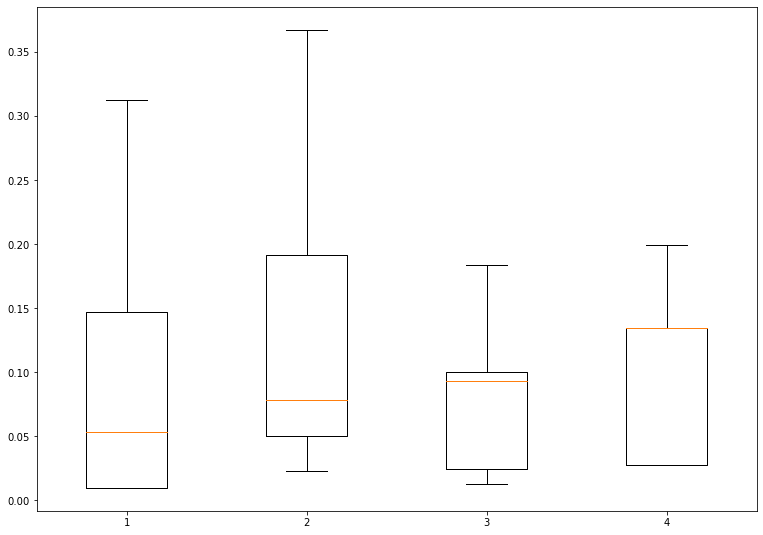

In [32]:
data_1 = np.array(tocke_vel[0]) 
data_2 = np.array(tocke_vel[1])  
data_3 = np.array(tocke_vel[2])  
data_4 = np.array(tocke_vel[3]) 
data = [data_1, data_2, data_3, data_4] 
  
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot(data) 
plt.show() 

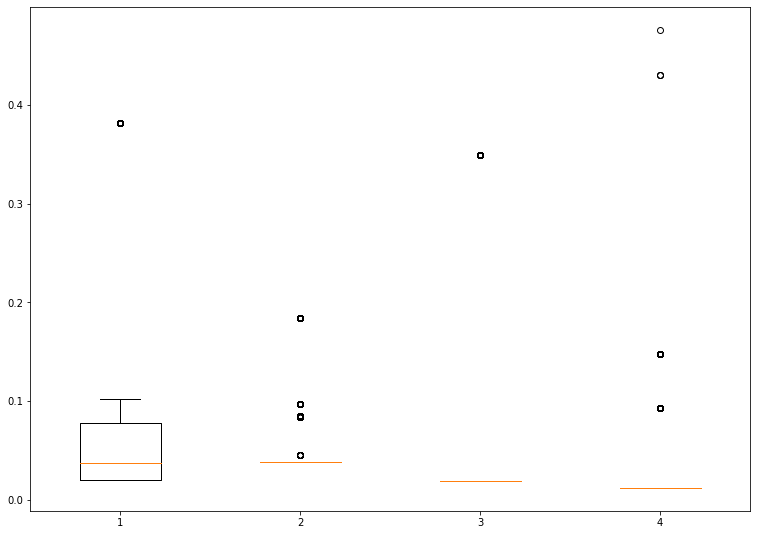

In [33]:
data_1 = np.array(tocke_mut[0]) 
data_2 = np.array(tocke_mut[1])  
data_3 = np.array(tocke_mut[2])  
data_4 = np.array(tocke_mut[3]) 
data = [data_1, data_2, data_3, data_4] 
  
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot(data) 
plt.show() 

5. Ako ste implementirali turnirsku selekciju, probajte nad nekom težom funkcijom (f6 ili f7) izvesti
algoritam koristeći različite veličine turnira. Pomaže li veći turnir algoritmu da pronađe bolja
rješenja? Ako ste implementirali selekciju roulette wheel, isprobajte više vrijednosti omjera odabira
najbolje i najlošije jedinke (skaliranje funkcije cilja) te komentirajte dobivene rezultate (također
možete isprobati generacijsku i eliminacijsku varijantu)

In [34]:
rez_f6 = []
rez_f7 = []

for k in [3, 10, 25]:
    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=10, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=10000, epsilon=1e-6, k=k, ispis=False)
    rez_f6.append(gen_alg.pokreni(Funkcija(f6), krizanje_aritmeticko ,VrstaMutacije.uniformna_r))

    gen_alg = GenetskiAlgoritam(prikaz=Prikaz.realni, velicina=25, dg=-50, gg=150, dimenzije=2, p_mutacije=0.099, br_evaluacija_fje_cilja=10000, epsilon=1e-6, k=k, ispis=False)
    rez_f7.append(gen_alg.pokreni(Funkcija(f7), krizanje_heuristicko ,VrstaMutacije.uniformna_r))


Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-0.92942663 -2.99770781]
Vrijednost funkcije dobrote za nju je:  -0.009715909877539175 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [ 0.0003395 -0.0004899]
Vrijednost funkcije dobrote za nju je:  -0.04627797046097381 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-4.90733804 -3.91411771]
Vrijednost funkcije dobrote za nju je:  -0.037224075578215055 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-1.24947203  0.7502197 ]
Vrijednost funkcije dobrote za nju je:  -1.4897534140654278 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-0.01330178  0.04452391]
Vrijednost funkcije dobrote za nju je:  -0.00215991185026293 

Dosegnut je maksimalan broj evaluacija fje cilja.
Najbolja jedinka je:  [-0.20692954  0.15777411]
Vrijednost funkcije dobrote za nju je:  -0.6267455000340035 



In [35]:
rez_k_f6 = np.array(rez_f6)
rez_k_f7 = np.array(rez_f7)
pd.DataFrame(np.column_stack((rez_k_f6, rez_k_f7)), [3, 10, 25], ['najbolja jedinka f6', 'dobrota f6', 'najbolja jedinka f7', 'dobrota f7'])

,najbolja jedinka f6,dobrota f6,najbolja jedinka f7,dobrota f7
3,[-0.92942663 -2.99770781],-0.00971591,[ 0.0003395 -0.0004899],-0.046278
10,[-4.90733804 -3.91411771],-0.0372241,[-1.24947203 0.7502197 ],-1.48975
25,[-0.01330178 0.04452391],-0.00215991,[-0.20692954 0.15777411],-0.626746
